# Adjoint Method within PT-MPO for calculating the gradient

In this tutorial, we use the adjoint method to calculate the gradient of an objective function within PT-MPO. This tutorial is intended to be read in conjunction with the supplemental information in \[insert citation here\]

The goal of this tutorial is to calculate the gradient of some generic objective function $Z$ which only depends on the value of the final density matrix $\rho_f$. To do this we will need to evaluate each part of the sum in equation S1 of the afformentioned supplement.

$$
\frac{\partial Z}{\partial c_a}=\sum_n\sum_{i,j,k}^{d_{H_S}^2}
\frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}
\frac{\partial U^{jk}_n}{\partial c_a},
$$

where the last term on the right hand side of the equation is the derivative of the system propagators $U$ (which are constructed from the system hamiltonian) and the control parameter. This needs to be calculated which is shown below. The middle term is the derivative of the final state with respect to the system propagators. This is the computationally difficult part that is performed by the forward-propagation and back-propagation in the adjoint method. Finally the first term is the derivative of the objective function with respect to the final state, which we will later show that in the case of fidelity between a pure target state $|\sigma\rangle$ and $\rho_f$, reduces to simply $\sigma^T$, but more generally this will also need to be calculated.

A considerably more in-depth discussion of the construction of this method is given in the supplement.

## The `oqupy.gradient` method

The `oqupy.gradient` method is defined as follows:

``` python
def gradient(
        system: Union[System, TimeDependentSystem],
        gradient_dynamics: Optional[GradientDynamics] = None,
        initial_state: Optional[ndarray] = None,
        target_state: Optional[ndarray] = None,
        dprop_dparam_list: Optional[List[ndarray]] = None,
        dprop_times_list: Optional[ndarray] = None,
        dt: Optional[float] = None,
        num_steps: Optional[int] = None,
        start_time: Optional[float] = 0.0,
        process_tensor: Optional[Union[List[BaseProcessTensor],
                                       BaseProcessTensor]] = None,
        control: Optional[Control] = None,
        get_forward_backprop_list: Optional[bool] = False,
        record_all: Optional[bool] = True,
        subdiv_limit: Optional[int] = SUBDIV_LIMIT,
        liouvillian_epsrel: Optional[float] = INTEGRATE_EPSREL,
        progress_type: Optional[Text] = None) -> GradientDynamics:
```
Broadly speaking, `oqupy.gradient` requires a system, an initial state and a target state in hilbert space, a process tensor, from which it can compute $\frac{\partial\rho_f^i}{\partial U^{jk}_n}$. Additionally, `oqupy.gradient` requires `dprop_dparam_list` which is given in the form of a list of $(d^2_{H_S},d^2_{H_S})$ matrices in Liouville space which are $\frac{\partial U^{jk}_n}{\partial c_a}$, as well as `dprop_times_list`, an array of the times that corrispond to the $\frac{\partial U^{jk}_n}{\partial c_a}$ in that position in the list. These are all requirements in order to perform a `oqupy.gradient` call, and the result is returned within a `oqupy.GradientDynamics` instance. If $\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ is already known, it is possible to re-use this result with a different list of $\frac{\partial U^{jk}_n}{\partial c_a}$, by passing the `oqupy.GradientDynamics` instance to the `oqupy.gradient` function, and the new `dprop_dparam_list` and `dprop_times_list`. Since the adjoint method has already been computed, there is no need to supply the initial or target state, however a process tensor and system instances are still necessary to construct the deriviatives.

We now show examples of how this is implemented


In [45]:
import numpy as np
import oqupy
import matplotlib.pyplot as plt

### Overview
1. Set up the physical model
2. Setting up the objective function (calculating the extra terms necessary to obtain the gradient)
3. Using the adjoint method
4. Comparison with brute force finite difference

## Setting up the system and model

The first thing we do is set up the problem, generate a process tensor, and save it to our hard drive so we don't need to regenerate the PT every time you need to reload this script.

We choose the spin-boson model of a quantum dot (QD) with appropriately chosen parameters as in \[ramsay,our_paper\].

We model a quantum dot coupled to a bosonic environment evolving under a total hamiltonian of 

$H_S+H_B+H_{SB}$, where we use a standard, deformation potential coupling of $H_{SB}=s_z\sum_q(g_qb_q+g_q^*b_q^\dagger)$. This system-environment interaction is controlled by the following super-ohmic spectral density,
$$
J(\omega) = 2\alpha\omega^3 \omega_c^{-2}\exp\left[-\frac{\omega^2}{\omega_c^2}\right].
$$ 

We choose units where $\hbar=1$ and we define the physical parameters as:

In [46]:
alpha = 0.126
omega_cutoff = 3.04
temperature = 5 * 0.1309 # 1K = 0.1309/ps in natural units

And the numerical parameters for tempo as:

In [47]:
dt = 0.05
dkmax = 60
esprel = 10**(-7)
max_time = 5

In [48]:

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)

tempo_params = oqupy.TempoParameters(dt=dt, dkmax=dkmax, epsrel=esprel)

In [49]:
generate_process_tensor = True

In [50]:
if generate_process_tensor:
    process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                            start_time=0,
                                            end_time=max_time,
                                            parameters=tempo_params,
                                            # progress_type='silent'
                                            )

    process_tensor.export('optimisation_pt.processTensor',overwrite=True)

else:
    process_tensor = oqupy.import_process_tensor(
                'optimisation_pt.processTensor','simple')

print('internal bond dimensions')
print(process_tensor.get_bond_dimensions())

--> PT-TEMPO computation:
  4.0%    4 of  100 [#---------------------------------------] 00:00:00

100.0%  100 of  100 [########################################] 00:00:20
Elapsed time: 20.6s
internal bond dimensions
[ 1  4 10 16 18 21 25 25 27 31 31 30 30 32 33 35 34 37 37 37 38 39 38 39
 39 38 38 37 39 39 41 43 40 39 41 42 41 42 42 41 41 42 43 42 42 41 40 41
 40 39 40 40 40 39 39 40 39 39 39 38 39 37 37 39 38 38 37 38 37 36 37 36
 36 35 36 35 34 34 35 32 31 32 29 29 28 29 28 25 24 22 20 17 17 15 15 13
 12  9  6  3  1]


### Defining a system

For simplicity we have chosen a model that can be well approximated as a two level system. In this case we assume that our system is coupled to fields conjugate to $s_z$ and $s_x$. As in the main text we treat them as piecewise constant over the discrete timesteps of the process tensor. This gives us a system hamiltonian

$$
H_S=h_xs_x + h_zs_z
$$

Where the field strengths $h_x$ and $h_z$ are discritised into timesteps `dt`. 

In code:

In [51]:
from scipy.interpolate import interp1d
from oqupy.process_tensor import BaseProcessTensor
# function that returns the times that the density matrix is calculated at
from oqupy.helpers import get_full_timesteps

In [52]:
from typing import List,Tuple

def get_hamiltonian_discrete():
    """
    Returns a callable which takes a set of parameters for a given time and returns the corresponding Hamiltonian

    """
    def hamiltonian(hx,hy,hz):

        hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
        hz_sz = 0.5 * oqupy.operators.sigma('z') * hz
        hy_sy = 0.5 * oqupy.operators.sigma('y') * hy 

        return hz_sz + hx_sx + hy_sy
    
    return hamiltonian


## Setting up the gradient
### Defining a objective function

The most generic objective function conceivable can be evaluated by equation S1. For definiteness we will focus on the widely used quantum fidelity. For two valid density matrices, the general formula has a rather unwieldly definition.
$$
\mathcal{F}(\rho_A,\rho_B) = \left(\text{tr}\left[\sqrt{\sqrt{\rho_A}\rho_B\sqrt{\rho_A}}\right]\right)^2
$$

In the main text we consider the case where one of the density matrices (in our case the target density matrix) is a *pure* density matrix corresponding to the state $|\sigma\rangle$. So the formula for the fidelity of a control protocol resulting in a final density matrix $\rho_f$ reduces to

$$
\mathcal{F} = \langle\sigma|\rho_f|\sigma\rangle.
$$

The goal of this tutorial is to show how one would calculate $\frac{\partial\mathcal{F}}{\partial c_a}$. As previously mentioned, it is possible to compute the derivative of a general objective function, by identifying $\frac{\partial Z}{\partial \rho_f^i}$, however for simplicity we will explain the functionality of the package using the example in the main text.

We state in the main text that the fidelity w.r.t. a pure state can be computed within PT-MPO tensor network by starting with the pure state in Hilbert space,$|\sigma\rangle$ constructing the density matrix associated for this state, $\rho_t^{i,j} = |\sigma\rangle\langle\sigma|$, of shape $(d_{H_S},d_{H_S})$ of the taking the transpose of the density matrix, $(\rho_t^T)^{i,j}$, converting this into Liouville space, which we label as $(\rho_t^T)^i$ which is a vector of dimension $d^2_{H_S}$. Next, we compute the target state for a given protocol, $\rho_f^i$, which is in *Liouville* space (a vector). Finally we find the fidelity is calculated by the sum of the element wise product of these two objects
$$
\mathcal{F} = \sum_i^{d^2_{H_S}} \rho_f^i\rho_t^i,
$$

which is the same as the diagram shown in Fig. 1 of the main text, and Fig. S2.

This is an intentional departure from the notation used in the supplement, in order to clearly distinguish when we are talking about the *target state* in Hilbert space, $|\sigma\rangle$, a *density matrix* in Hilbert space corresponding to the pure target state, $\rho_t^{i,j}$, and finally a vectorised density matrix in Liouville space, $\rho_t^i$ 

This fact can be seen by understanding how the vectorisation works. `oqupy` predominantly uses numpy, and `numpy.reshape` uses c notation which is a row vectorisation by default. For a two level system this looks like.

$$\rho = \begin{bmatrix}
\rho_{11}&\rho_{12}\\
\rho_{21}&\rho_{22}

\end{bmatrix}
\rightarrow

\begin{bmatrix}
\rho_{11}\\ \rho_{12}\\
\rho_{21}\\ \rho_{22}

\end{bmatrix}
$$

In Einstein notation the formula for the fidelity is

$$
\mathcal{F} = \langle\sigma|\rho_f|\sigma\rangle = \sum_{i,j}^{d^2_{H_S}}(\sigma^*)^i\rho_f^{i,j}\sigma^j,
$$
and
$$
\rho_T^{ij} = |\sigma\rangle\langle\sigma| = \sigma^i(\sigma^*)^j.
$$

Because the operators are hermitian, conjugating a matrix is equivalent to taking the transpose, so combining the two previous equations, and noting carefully the order of the indices,
$$
\mathcal{F} = \sum_{i,j}^{d^2_{H_S}}(\sigma^*)^i\sigma^j\rho_f^{i,j} = \sum_{i,j}^{d^2_{H_S}}\rho_t^{ji}\rho_f^{ij}.
$$

By considering how the vectorisation works one can see how this is achieved by a scalar product in Liouville space of $(\rho_t^{T})^{ij}$ and $\rho_f^{ij}$.


### Obtaining the derivative of the propegator w.r.t. the control parameter $c_a$

Now we have to identify the derivative of the system propagator with respect to the control parameter which we wish to optimise in our hamiltonian.
In the case of our Hamiltonian this is $h_\bullet$. Since evalutating the propagator is a $(d_{H_s}^2,d_{H_s}^2)$, this is cheap so it is not prohibitive to do this through finite differencing. I haven't provided a general function that will do this for some general hamiltonian, but it is not hard to write, and I give you an example of how to write one below.

The important part of this step is to note that in the main text and supplement, for simplicity and clarity of diagrams, we have used a simple, first order, Suzuki-Trotter splitting 

$$\exp[\mathcal{L}_{\text{tot}}(\texttt{t})\texttt{dt}]\rightarrow\exp[\mathcal{L}_{\text{env}}(\texttt{t})\texttt{dt}]\exp[\mathcal{L}_{\text{S}}(\texttt{t}+\texttt{dt/2})\texttt{dt}]$$

Whereas the `oqupy` package uses a symmeterised splitting

$$
\exp[\mathcal{L}_{\text{tot}}(\texttt{t})\texttt{dt}]\rightarrow
\exp[\mathcal{L}_S(\texttt{t}+3\texttt{dt}/4)\texttt{dt}/2]
\exp[\mathcal{L}_{\text{env}}(\texttt{t}+\texttt{dt}/2)\texttt{dt}]
\exp[\mathcal{L}_S(\texttt{t}+\texttt{dt/4})\texttt{dt}/2].$$

As such, instead of each timestep $t_n$ having a single system propagator, $U(t_n)$ that propagates forward one timestep, one must instead consider two system propagators, $U(t_n+\texttt{dt}/4)$, $U(t_n+3\texttt{dt}/4)$ that propagate forward two half timesteps. So if a derivative $\frac{\partial U_n}{\partial c_a}$ depends on timestep $n$, we must supply

$$
\frac{\partial U(t_n+\texttt{dt}/4)}{\partial c_a} + \frac{\partial U(t_n+3\texttt{dt}/4)}{\partial c_a}
$$

in pairs.

An example function does this below in the case we have on the main text where $c_a\rightarrow h_\bullet(n)$ where $h\in \{0,\texttt{dt},2\texttt{dt},\dots N\texttt{dt}\}$ so $\frac{\partial U_n}{\partial h_\bullet(a)}$ is only non-zero for $n=a$, and there is no sum over time in equation S1, as stated in supplement.

This is coded using finite differences as follows:

The practical way to implement the symmetrized trotter splitting is to figure out what times your control parameter $c_a$ depends on. Then once you have figured out what times your control parameter depends on, it is simply a matter of including both the pre time and post time to calculate dpropagator, and then summing over the resultant total derivatives at the end. 

In the case we consider here my control parameters are $h_\bullet(t)$ where $t\in \{0,\texttt{dt},2\texttt{dt},\dots N\texttt{dt}\}$, so each individual $h_\bullet(t)$ parameter depends only on a single timestep, and when we consider $h_\bullet(t)$ for all $t$ we use all timesteps. So the simplest way to do this is for each timestep used calculate both $U(t+\texttt{dt}/4)$ and $U(t+3\texttt{dt}/4)$ in pairs. The pairs of times needed can easilly be found by using the `get_half_timesteps` function.

## Pi Pulse gradient

Now let's see what the gradient of a pi pulse looks like. We make use of the helper funciton that generates a list of all of the whole timesteps where we are able to calculate the density matrix and thus the expectation values of our simulation. From there we specify a protocol that is a $\pi$ pulse

In [53]:

num_times = process_tensor.__len__()
times_fidelity = get_full_timesteps(process_tensor,start_time=0,inc_endtime=True)
times_gradient = get_full_timesteps(process_tensor,start_time=0,inc_endtime=False)

# pi pulse conjugate to s_x
h_x = np.ones(2*num_times) * np.pi / max_time
h_x = h_x.tolist()
h_z = np.zeros(2*num_times).tolist()
h_y = np.zeros(2*num_times).tolist()


parameters = list(zip(h_x,h_y,h_z))

system = oqupy.ParameterizedSystem(get_hamiltonian_discrete())



Now we obtain our list of $\frac{\partial U_n}{\partial c_a}$ for all our parameters

### Using adjoint method

The last thing we need to do is to provide a list of the times that we have provided $\frac{\partial U_n}{\partial c_a}$ at. This list should be *monotonly increasing*, once this is provided the gradient function handles the recombination described in the supplement

In [54]:
gradient_dynamics = oqupy.state_gradient(
                system=system,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+').T,
                process_tensor=process_tensor,
                parameters=parameters,
                return_dynamics=True,
                return_fidelity=True)

total_derivs_x = np.array([parameter[0] for parameter in gradient_dynamics['gradient']])
total_derivs_y = np.array([parameter[1] for parameter in gradient_dynamics['gradient']])
total_derivs_z = np.array([parameter[2] for parameter in gradient_dynamics['gradient']])

fidelity_final = gradient_dynamics['fidelity']
print(fidelity_final)
print(gradient_dynamics['dynamics'])

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
101


Once the `oqupy.GradientDynamics` object has been created and the adjoint method has been used to get $\frac{\partial \rho_f}{\partial U_n}$ for all $n$, we can reuse the object for a different set of $\frac{\partial U_n}{\partial c_k}$ without having to redo the entire adjoint calculation. By simply passing the previously outputted `gradient` object back into `oqupy.gradient()`, it automatically takes its result and we no longer need to specify the initial and target state as they have already been given, we just need to give the `dprop_dpram_list` and times

The final step is that we need to sum the elements from the pre and post propagators together. since they are held side by side, we can simply sum the adjacent elements.

In [ ]:
def sum_adjacent_elements(array:np.ndarray)-> np.ndarray:
    # maybe this goes in helpers.py or utils.py?
    half_the_size = array.size / 2
    assert (half_the_size).is_integer(), \
        'if one output from both pre and post node is given, result must be even'
    half_the_size = int(half_the_size)

    # https://stackoverflow.com/a/29392016
    summed_array = array.reshape((half_the_size,2)).sum(axis=1)
    return summed_array

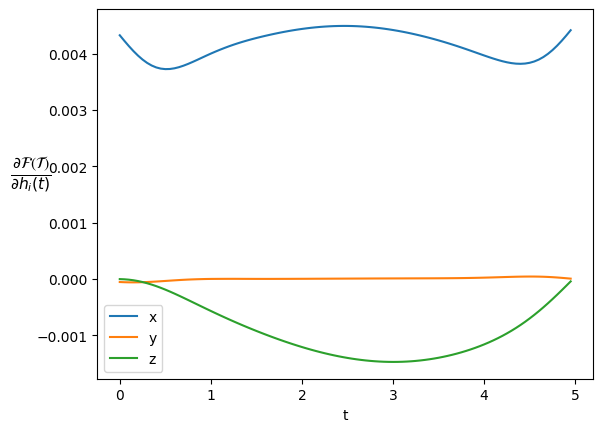

c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


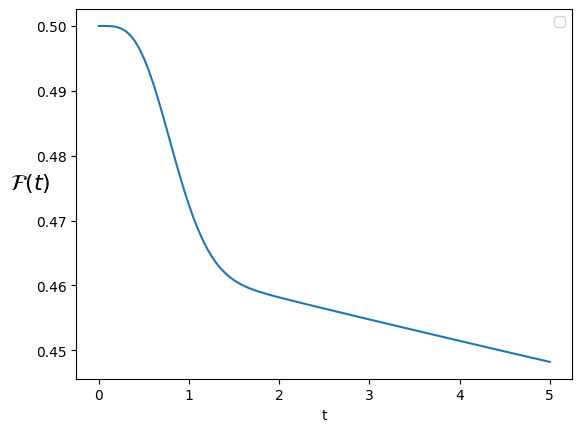

(0.9642525262732182-2.6585376374460137e-07j)


In [ ]:
from scipy.linalg import sqrtm

final_derivs_x = sum_adjacent_elements(total_derivs_x)
final_derivs_z = sum_adjacent_elements(total_derivs_z)
final_derivs_y = sum_adjacent_elements(total_derivs_y)

plt.figure()

plt.plot(times_gradient,final_derivs_x.real,label='x')
plt.plot(times_gradient,final_derivs_y.real,label='y')
plt.plot(times_gradient,final_derivs_z.real,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F(T)}}{\partial h_i (t)}$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()

target_state=oqupy.operators.spin_dm('z+')

plt.figure()

hs_dim = 2

target_ndarray = target_state
dynamics = gradient_dynamics['dynamics'] 
fidelity=[]

for state in dynamics.states:
    sqrt_final_state = sqrtm(state)
    intermediate_1 = sqrt_final_state @ target_state
    inside_of_sqrt = intermediate_1 @ sqrt_final_state
    fidelity.append((sqrtm(inside_of_sqrt).trace())**2)

plt.plot(times_fidelity,fidelity)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")

plt.legend()
plt.show()

print(fidelity_final)

## ARP gradient

Now let us choose a time-dependent example, a chirped ARP pulse. In this case our hamiltonian is given by $H_S = \Omega(t) s_x + \Delta(t) s_z$, and we parameterise 

$$\Omega(t) = \frac{\Theta_0}{\sqrt{2\pi\sqrt{a^2+\tau_0^4}}}\text{exp}\left[-\frac{(t-t_0)^2\tau_0^2}{2(a^2+\tau_0^4)}\right],
$$
$$
\Delta(t) = -\frac{at}{a^2+\tau_0^4},
$$

centred about time $t_0$, of pulse-width $\tau_0$ and of pulse area $\Theta_0$

For simplicity let's start with an unchirped $\pi$ pulse so $\Theta_0=\pi$ and $a=0$ so $\Delta (t)=0$, and 

$$\Omega(t) = \frac{\Theta_0}{\sqrt{2\pi}}\text{exp}\left[-\frac{t^2}{2\tau_0^2}\right].
$$

However you are more than welcome to play with the parameters (though you may need to generate a longer duration process tensor)!

We will plot the pulse for $5\text{ps}$ as before and centre the pulse about $t_0=2.5$


In [ ]:
a = 0
theta_0 = np.pi
tau_0=0.5
# pulse centre
t_0=2.5

from oqupy.helpers import get_half_timesteps 

half_time_steps = get_half_timesteps(process_tensor,0)

In [ ]:
def delta(t):
    # delta = -a*(t-t_0) / (a**2+tau_0**4)
    return np.ones(t.size,dtype='float64')

def omega(t): # changed tau_0 ** 2 _ > tau_0 ** 4 here?
    omega = theta_0 / (np.sqrt(2*np.pi * np.sqrt(a**2 + tau_0**4))) \
        * np.exp(-(t-t_0)**2 * tau_0**2 / (2*(a**2 + tau_0**4)))
    return omega

omega_vals = omega(half_time_steps)
delta_vals = delta(half_time_steps)
h_y = np.zeros(2*num_times).tolist()



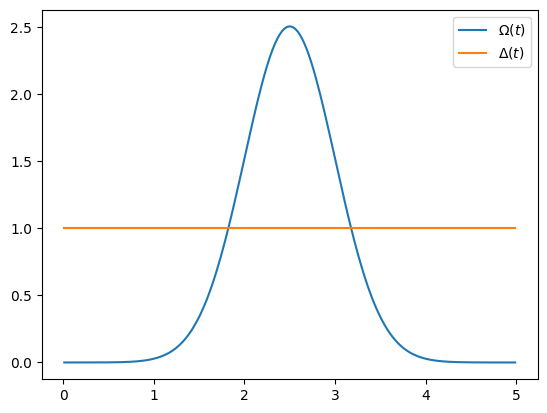

In [ ]:
plt.figure(3)
plt.plot(half_time_steps,omega_vals,label=r'$\Omega(t)$')
plt.plot(half_time_steps,delta_vals,label=r'$\Delta(t)$')
plt.legend()

Now we need the `dprop` list, this is more complicated now because our parameters are now $\Theta_0$ and $a$

The complication arises because previously we had that $\frac{\partial U_n}{\partial h_{\bullet,k}}$ was only nonzero for $u=k$, whereas $\frac{\partial U_n}{\partial \Theta_0}$ is nonzero for all $n$. The easiest way to solve this problem is to say that $\Omega(t)$ is $h_x$ and to use the chain rule,
$$
\frac{\partial \mathcal{F}(t)}{\partial \Theta_0} = \sum_n \frac{\partial{\rho_f}}{\partial U_n}
\frac{\partial U_n}{\partial h_x}\frac{\partial h_x}{\partial \Theta_0}
$$

The last term is just a scalar. 


In [ ]:
def arp_hamiltonian_deriv(t):
    omega = 1 / (np.sqrt(2*np.pi * np.sqrt(a**2 + tau_0**4))) \
        * np.exp(-(t-t_0)**2 * tau_0**2 / (2*(a**2 + tau_0**4)))
    return omega

In [ ]:

parameters_arp = list(zip(omega_vals,delta_vals,h_y))

gradient_arp = oqupy.state_gradient(
                system=system,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+').T,
                process_tensor=process_tensor,
                parameters=parameters_arp,
                return_dynamics=True)

omega_derivs =  np.array([parameter[0] for parameter in gradient_arp['gradient']])
delta_derivs = np.array( [parameter[1] for parameter in gradient_arp['gradient']])
hy_derivs = np.array( [parameter[2] for parameter in gradient_arp['gradient']])

dham_dtheta = arp_hamiltonian_deriv(half_time_steps)

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
101


In [ ]:
# apply last term of chain rule

omega_total_derivs = omega_derivs * dham_dtheta
delta_total_derivs = delta_derivs * a

dF_dTheta_0 = np.sum(omega_total_derivs)
dF_da = np.sum(delta_total_derivs)

print('the derivative of a pulse of area {} and chirp {} w.r.t:'.format(theta_0,a))
print('theta_0 = {}'.format(dF_dTheta_0))
print('a = {}'.format(dF_da))

the derivative of a pulse of area 3.141592653589793 and chirp 0 w.r.t:
theta_0 = (0.09248094600712745-6.264522259522645e-08j)
a = 0j


Now if all that is desired is to calculate $\frac{\partial\mathcal{F}}{\partial\Theta_0}$, and $\frac{\partial\mathcal{F}}{\partial a}$ this is a massive overkill, and doesn't offer much of a saving for computational resources. However in calculating these parameters, we have also calculated the gradient of the magnitude of $\Omega$ and $\Delta$ at the instantanious moments in time, which is interesting to plot in itself:

----------------------------------------------
Dynamics object: __unnamed__
 __no_description__
  length        = 101 timesteps 
  min time      = 0.0 
  max time      = 5.0 



c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


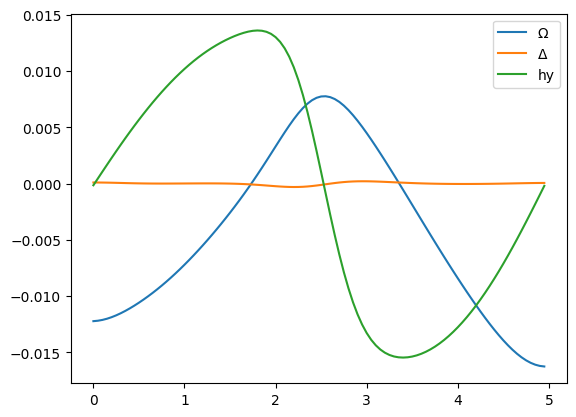

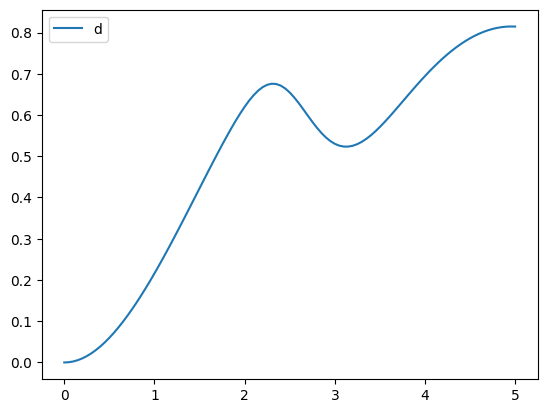

In [ ]:
omega_gradient = sum_adjacent_elements(omega_derivs)
delta_gradient = sum_adjacent_elements(delta_derivs)
hy_gradient = sum_adjacent_elements(hy_derivs)

plt.plot(times_gradient,omega_gradient.real,label=r'$\Omega$')
plt.plot(times_gradient,delta_gradient.real,label=r'$\Delta$')
plt.plot(times_gradient,hy_gradient.real,label='hy')
plt.legend()

target_state=oqupy.operators.spin_dm('z+')

plt.figure()


hs_dim = 2

target_ndarray = target_state
dynamics_arp = gradient_arp['dynamics'] 
v_final_state = target_state.reshape(hs_dim**2)
fidelity=[]

print(gradient_dynamics['dynamics'])

for state in dynamics_arp.states:
    v_state = state.reshape(hs_dim**2)
    fidelity.append(v_final_state.T@v_state)

plt.plot(times_fidelity,fidelity,label='d')

plt.legend()
plt.show()


### Comparison with Finite difference

#### Constant $\pi$ pulse

In [ ]:
from tqdm.contrib import tenumerate

def compute_finite_difference_brute(
                        pt_instance: oqupy.SimpleProcessTensor,
                        hamiltonian,
                        initial_state,
                        target_state,
                        times,
                        operator,
                        h = 10**-6):
    """ doesn't use the adjoint method, just computes the frichét derivatives by
    brute force"""

    assert operator.shape[0] == pt_instance.hilbert_space_dimension,\
         'input operator is a different H.S. dimension to the system'
    dt = pt_instance.dt
    def hamiltonian_perturbed(operator,h,dt,time):
        def _hamiltonian_perturbed(t):
            if time-dt/2 < t < time+dt/2:
                return hamiltonian(t) + h * operator
            return hamiltonian(t)
        return _hamiltonian_perturbed

    derivative_array = np.zeros(times.size,dtype=np.complex128)
    for i,time in tenumerate(times):
        ham_plus_h = hamiltonian_perturbed(operator,h,dt,time)
        ham_minus_h = hamiltonian_perturbed(operator,-h,dt,time)

        system_plus_h = oqupy.TimeDependentSystem(ham_plus_h)
        system_minus_h = oqupy.TimeDependentSystem(ham_minus_h)

        dynamics_forward = oqupy.compute_dynamics(
                    system_plus_h,
                    initial_state,
                    start_time=0,
                    process_tensor=pt_instance,
                    record_all=False,
                    progress_type='silent')
        dynamics_backward = oqupy.compute_dynamics(
                    system_minus_h,
                    initial_state,
                    start_time=0,
                    process_tensor=pt_instance,
                    record_all=False,
                    progress_type='silent')
        final_state_forward = dynamics_forward.states[0,:,:]
        final_state_backward = dynamics_backward.states[0,:,:]

        fidelity_forward = 1 - np.matmul(target_state,final_state_forward).trace()
        fidelity_backward = 1 - np.matmul(target_state,final_state_backward).trace()

        derivative = (fidelity_forward - fidelity_backward) / (2 * h)

        derivative_array[i] = derivative
        np.save('deriv_array',derivative_array)

    return derivative_array



In [ ]:
generate_finite_differnce_z = False
generate_finite_differnce_x = False

In [ ]:
if generate_finite_differnce_z:
    fd_z = compute_finite_difference_brute(
                process_tensor,
                hamiltonian_t,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times_gradient,
                operator=0.5*oqupy.operators.sigma('z')
                )

    np.save('constant_z',fd_z)


In [ ]:
if generate_finite_differnce_x:
    fd_x = compute_finite_difference_brute(
                process_tensor,
                hamiltonian_t,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times,
                operator=0.5*oqupy.operators.sigma('x')
                )
    np.save('constant_x',fd_x)


In [ ]:

constant_x = np.load('constant_x.npy')
constant_z = np.load('constant_z.npy')
plt.plot(times,constant_x.real,label='fd_x')
plt.plot(times,constant_z.real,label='fd_z')

plt.plot(times,final_derivs_x.real,label='adj_x')
plt.plot(times,final_derivs_z.real,label='adj_z')

plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'constant_x.npy'

#### ARP pulse

In [ ]:
generate_arp_fd_x = False
generate_arp_fd_y = False
generate_arp_fd_z = False

In [ ]:
if generate_arp_fd_x:
    arp_x = compute_finite_difference_brute(
                process_tensor,
                arp_hamiltonian,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times,
                operator=0.5*oqupy.operators.sigma('x')
                )
    np.save('arp_x',arp_x)


In [ ]:
if generate_arp_fd_z:
    arp_z = compute_finite_difference_brute(
                process_tensor,
                arp_hamiltonian,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times,
                operator=0.5*oqupy.operators.sigma('z')
                )
    np.save('arp_z',arp_z)


In [ ]:
if generate_arp_fd_y:
    arp_y = compute_finite_difference_brute(
                process_tensor,
                arp_hamiltonian,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times,
                operator=0.5*oqupy.operators.sigma('y')
                )
    np.save('arp_y',arp_y)

In [ ]:
arp_x = np.load('arp_x.npy')
arp_y = np.load('arp_y.npy')
arp_z = np.load('arp_z.npy')

plt.figure(4)
plt.plot(times,-1*omega_gradient.real,label=r'$\Omega$ adj')
plt.plot(times,-1*delta_gradient.real,label=r'$\Delta$ adj')
plt.plot(times,-1*hy_gradient,label=r'$h_y$ adj')

plt.plot(times,arp_x.real,label=r'$\Omega$ fd')
plt.plot(times,arp_z.real,label=r'$\Delta$ fd')
plt.plot(times,arp_y.real,label=r'$h_y$ fd')
plt.legend()




NameError: name 'np' is not defined